# 2 July 2022: Currency Conversion and Price Adjustment
We left off having determined the four currencies with which Knoedler conducted the vast majority of its business—US dollars, French francs, British pounds, and German marks. In order to get a sense for the dealer's activity in terms of transacted value (rather than by volume, which is where we began in the first journal), we need to be able to standardize all the transactions—not only in a single currency but also at a single moment in time.

I'm not an economist, so I can only imagine that, from a methodological point of view, converting various currencies from 1871–1971 to present-day dollars is, well, complicated. However, all I want is an estimate, so at least for now I won't quibble much with questions of conversion methodology in favor of getting a working prototype.

A cursory web search revealed that a comprehensive currency converter for the past few centuries is tough to come by. I did find <a href="https://www.historicalstatistics.org/Currencyconverter.html" target="_blank">this one</a>, though, which conveniently cobbles together historical data from a variety of sources and seems like it will suit our needs. In fact, it allows us to specify not only target and destination currencies but also target and destination years. The trouble is, we can't simply export everything we need all at once. Instead, we're stuck submitting and resubmitting the webform over and over. Sounds time-consuming and boring. Why not try to automate the process instead? So I took a break to write a very crude but functional <a href="https://github.com/zrottman/data-exploration/tree/main/knoedler/scripts/currency_scraper.py" target="_blank">web scraper</a> that will do this tedious work for me.

Our destination currency and destination year are always the same—we want everything in 2015 US dollars (2015 is the latest this particular calculator will go)—so all my script does is fill out the form with the remaining pertinent information (i.e., target currency and target year), submit it, and extract the results, over and over: it loops through our four target currencies (marks, francs, pounds, and dollars) and through every target year (from 1871–1971). Then the script writes the results to a .csv file that we will easily be able to load and merge with our Knoedler dataset.

I've already gone ahead and run the script to generate our rough currency conversions, so let's start by taking a look at the results.

In [1]:
# Standard imports
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
curr_conversions = pd.read_csv('../data/knoedler_curr_conversion.csv', names=['currency', 'year', 'USD-2015'])
curr_conversions

,currency,year,USD-2015
0,US dollar [1791-2015],1871,23.710702592087177
1,US dollar [1791-2015],1872,22.754468125340747
2,US dollar [1791-2015],1873,20.694653379812905
3,US dollar [1791-2015],1874,21.01800442762689
4,US dollar [1791-2015],1875,20.665928437839778
...,...,...,...
702,French franc [1960-2015],1967,1.1029163023764728
703,French franc [1960-2015],1968,1.0751344341721853
704,French franc [1960-2015],1969,0.9996416558760816
705,French franc [1960-2015],1970,0.880538402819148


Looks clean enough. However, there are a few issues I'm aware of.

First, the calculator I used includes several sub-currencies to account for historical changes to a country's bank notes. For instance, in Germany from 1871 to 1971 we have in fact three currencies: the mark (1871–1924), the reichsmark (1924–1948), and the Deutsche mark (1948 and on). Here's what I mean:

In [2]:
curr_conversions.currency.value_counts()

US dollar [1791-2015]               101
UK pound [1658-2015]                101
German mark [1871-1924]             101
German reichsmark [1924-1948]       101
German Deutsche Mark [1948-2015]    101
French franc [1795-1960]            101
French franc [1960-2015]            101
Name: currency, dtype: int64

This means that the <code>currency</code> column will need to be simplified and standardized, so that we're dealing with just four overarching currencies, since that's how the Knoedler dataset categorizes transactions. I'll get to this in a moment.

A second issue is that there are a lot of <code>Null</code> values for all those situations when the calculator didn't return anything (i.e., trying to output the 2015 USD value of 1 German mark [1871–1924] in 1925, a year which falls outside of the range of that particular sub-crrency). That's easy, I'll just convert the <code>Null</code> values to <code>np.nan</code> and then drop 'em, since we don't need them.

Let's fix these two issues before getting to the third and final issue of which I'm aware.

In [3]:
# Make a dictionary for replacements
replacements_dict = {
    'Null' : np.nan,
    'US dollar [1791-2015]' : 'dollars',
    'UK pound [1658-2015]': 'pounds',
    'German mark [1871-1924]' : 'marks',
    'German reichsmark [1924-1948]': 'marks',
    'German Deutsche Mark [1948-2015]' : 'marks',
    'French franc [1795-1960]' : 'francs',
    'French franc [1960-2015]' : 'francs'
}

# Perform replacements and drop null cells
curr_conversions.replace(replacements_dict, inplace=True)

# Drop null cells
curr_conversions.dropna(inplace=True)

curr_conversions.currency.value_counts()

marks      102
francs     102
dollars    101
pounds     101
Name: currency, dtype: int64

This is pretty much what we expect to see, although there seem to be duplicate entries for marks and francs (we expect only 101 rows of conversions, not 102). This is our third issue—let's see what's going on.

In [4]:
# Slice new marks- and francs-specific DataFrames
marks = curr_conversions[curr_conversions.currency == 'marks']
francs = curr_conversions[curr_conversions.currency == 'francs']

# Print the dupes
print(marks[marks.year.duplicated(keep=False)])
print()
print(francs[francs.year.duplicated(keep=False)])

    currency  year                USD-2015
255    marks  1924  2.8855419606662454e-12
356    marks  1924      2.8855419606662456
380    marks  1948    0.059955348310278676
481    marks  1948      0.5995534831027867

    currency  year              USD-2015
594   francs  1960  0.014698036900964745
695   francs  1960    1.4698036900964744


Interesting. In each of these cases we're facing a year in which the currency changed or was reissued, which accounts for the overlap: The 1924 discrepancy has to do with the conversion of the drastically devalued mark to the reichsmark (a conversion rate of 1 x 10 <sup>12</sup>—yikes). The 1948 dupes, on the other hand, reflect the change from the old reichsmarks to the new Deutsche mark at a rate of 10 to 1. Similar situation with the French franc: one new franc, introduced in 1960, was exchanged for 100 old francs.

All of this may or may not matter, depending on whether there are any transactions with these currencies in these particular years. If we <i>do</i> have relevant transactions, we'll have to figure out which exchange rate maks the most sense. Otherwise we can just ignore these rows.

Let's have a peak. First let's load our Knoedler dataset.

In [5]:
# Load Knoedler dataset
knoedler = pd.read_csv('../data/knoedler.csv')

# Specify just the columns we need for this notebook
columns = [
    'pi_record_no',
    'entry_date_year', 
    'sale_date_year', 
    'purch_amount', 
    'purch_currency',
    'knoedpurch_amt',
    'knoedpurch_curr',
    'price_amount', 
    'price_currency',
    'knoedshare_amt', 
    'knoedshare_curr'
]

# Slice out the columns we want for legibility's sake
knoedler = knoedler[columns]

# Consolidate dollar/dollars
knoedler.loc[knoedler.purch_currency == 'dollar', 'purch_currency'] = 'dollars'

knoedler

/var/folders/_h/vtjqyqq96hv8fw2d_ybkq1sc0000gn/T/ipykernel_19553/615467852.py:2: DtypeWarning: Columns (5,6,7,36,42,43,44,47,50,51,52,54,55,56,68,71,72,73,75,76,77,80,88) have mixed types. Specify dtype option on import or set low_memory=False.
  knoedler = pd.read_csv('../data/knoedler.csv')


,pi_record_no,entry_date_year,sale_date_year,purch_amount,purch_currency,knoedpurch_amt,knoedpurch_curr,price_amount,price_currency,knoedshare_amt,knoedshare_curr
0,K-1,1906.0,1907.0,48000,francs,20.0,dollars,15000,dollars,NaN,NaN
1,K-2,1876.0,1878.0,75,dollars,NaN,NaN,37.50,dollars,NaN,NaN
2,K-3,1876.0,1878.0,75,dollars,NaN,NaN,37.50,dollars,NaN,NaN
3,K-4,1876.0,1877.0,150,dollars,NaN,NaN,100,dollars,NaN,NaN
4,K-5,1876.0,1877.0,250,dollars,NaN,NaN,202,dollars,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
40245,K-40442,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN
40246,K-23858,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN
40247,K-23859,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN
40248,K-40336,1902.0,1905.0,14375,dollars,NaN,NaN,20000,dollars,NaN,NaN


Now let's see if we have transactions denominated in marks in either 1924 or 1948 or transactions denominated in francs in 1960.

In [6]:
# Create masks for legibility
mask1924 = (
    (knoedler['entry_date_year'] == 1924) | 
    (knoedler['sale_date_year'] == 1924)
)

mask1948 = (
    (knoedler['entry_date_year'] == 1948) | 
    (knoedler['sale_date_year'] == 1948)
)

mask1960 = (
    (knoedler['entry_date_year'] == 1960) | 
    (knoedler['sale_date_year'] == 1960)
)

maskmarks = (
    (knoedler['purch_currency'] == 'marks') | 
    (knoedler['knoedpurch_curr'] == 'marks') | 
    (knoedler['price_currency'] == 'marks') | 
    (knoedler['knoedshare_curr'] == 'marks')
)
maskfrancs = (
    (knoedler['purch_currency'] == 'francs') | 
    (knoedler['knoedpurch_curr'] == 'francs') | 
    (knoedler['price_currency'] == 'francs') | 
    (knoedler['knoedshare_curr'] == 'francs')
)

print("Marks-denominated transactions, 1924: {0}".format(len(knoedler[maskmarks & mask1924])))
print("Marks-denominated transactions, 1948: {0}".format(len(knoedler[maskmarks & mask1948])))
print("Francs-denominated transactions, 1960: {0}".format(len(knoedler[maskfrancs & mask1960])))

Marks-denominated transactions, 1924: 0
Marks-denominated transactions, 1948: 0
Francs-denominated transactions, 1960: 0


Just what we want to see! No marks-denominated transactions in 1924 or 1948, and no francs-denominated transactions in 1960. In that case, I'm just going to delete the duplicate years in the <code>curr_conversions</code> DataFrame.

In [7]:
# Remake masks for currency dataset 
maskmarks = (curr_conversions['currency'] == 'marks')
maskfrancs = (curr_conversions['currency'] == 'francs')
mask1924 = (curr_conversions['year'] == 1924)
mask1948 = (curr_conversions['year'] == 1948)
mask1960 = (curr_conversions['year'] == 1960)

# Get the index numbers of the rows we want to drop
dupes_index = (
    curr_conversions[(maskmarks & (mask1924 | mask1948)) | (maskfrancs & mask1960)]
    .drop_duplicates(subset='year')
    .index
)

# Drop 'em!
curr_conversions.drop(index=dupes_index, inplace=True)

curr_conversions.shape

(403, 3)

At this point, we are getting close to being ready to merge our two DataFrames. Let's think a little about how this is going to work.

Remember from the previous notebook that our <code>knoedler</code> DataFrame has four transaction currency columns in play:
<ol>
    <li><code>purch_currency</code></li>
    <li><code>knoedpurch_curr</code></li>
    <li><code>price_currency</code></li>
    <li><code>knoedshare_curr</code></li>
</ol>
Each of these four transaction currency columns is paired with a matching transaction amount columns:
<ol>
    <li><code>purch_amount</code></li>
    <li><code>knoedpurch_amt</code></li>
    <li><code>price_amount</code></li>
    <li><code>knoedshare_amt</code></li>
</ol>
Thus we have solo and joint, inbound and outbound transactions. The only thing that's missing is the year—as we saw in the first notebook, there are two columns for this:
<ol>
    <li><code>entry_date_year</code></li>
    <li><code>sale_date_year</code></li>
</ol>

As a result, we would expect to find four categories of transaction, each of which would require three valid values to be considered "complete":
<ol>
    <li>Solo Knoedler acquisition: <code>entry_date_year</code> + <code>purch_currency</code> + <code>purch_amount</code></li>
    <li>Shared Knoedler acquisition: <code>entry_date_year</code> + <code>knoedpurch_curr</code> + <code>knoedpurch_amt</code></li>
    <li>Solo Knoedler sale: <code>sale_date_year</code> + <code>price_currency</code> + <code>price_amount</code></li>
    <li>Shared Knoedler sale: <code>sale_date_year</code> + <code>knoedshare_curr</code> + <code>knoedshare_amt</code></li>
    </ol>

What I plan to do, then, is add four additional columns to the <code>knoedler</code> dataset, which contain multipliers that get us from the target year/currency/amount trio to destinatation year/currency/amount—in this case, 2015 dollars. For the sake of consistency, how about something like:
<ul>
    <li><code>purch_conversion</code></li>
    <li><code>knoedpurch_conversion</code></li>
    <li><code>price_conversion</code></li>
    <li><code>knoedshare_conversion</code></li>
</ul>
    
Each of these columns will just hold a multipler number, which means we'll ultimately need four additional columns for the final converted and adjusted value in 2015 US dollars.

In any case, in order to append these four new multipler columns above, I believe that I am going to have to perform four separate joins on the <code>knoedler</code> dataset—one for each of these four transaction categories.

I want to pause here a moment, though. This idea of there being four distinct categories of transaction, each of which requires three requisite pieces of information to be valid and "complete," is really just an assumption at this point. To reiterate: According to my understanding of the dataset thus far, we would expect to find <code>entry_date_year</code> values paired with a purchase currency column (either <code>purch_currency</code> or <code>knoedpurch_curr</code>) and a purchase amount column (either <code>purch_amount</code> or <code>knoedpurch_amt</code>). Likewise, we would expect to find <code>sale_date_year</code> values paired with a sale currency column (either <code>price_currency</code> and <code>knoedshare_curr</code>) and a sale price column (either <code>price_amount</code> or <code>knoedshare_amt</code>). To provide a bit more guidance as to whether this assumption is correct or not, let's make sure we're seeing adequate representation in the dataset for items that meet these conditions.

Let's start by looking for "complete" transactions:

In [8]:
# Create masks for legibility

complete_purchase_solo = (
    (knoedler.purch_currency.notnull()) & 
    (knoedler.purch_amount.notnull()) & 
    (knoedler.entry_date_year.notnull())
)

complete_purchase_shared = (
    (knoedler.knoedpurch_curr.notnull()) & 
    (knoedler.knoedpurch_amt.notnull()) &
    (knoedler.entry_date_year.notnull())
)

complete_sale_solo = (
    (knoedler.price_currency.notnull()) & 
    (knoedler.price_amount.notnull()) &
    (knoedler.sale_date_year.notnull())
)

complete_sale_shared = (
    (knoedler.knoedshare_curr.notnull()) & 
    (knoedler.knoedshare_amt.notnull()) &
    (knoedler.sale_date_year.notnull())
)


# Count up complete transactions

complete_purchase_solo_count = len(knoedler[complete_purchase_solo])

complete_purchase_shared_count = len(knoedler[complete_purchase_shared])

complete_sale_solo_count = len(knoedler[complete_sale_solo])

complete_sale_shared_count = len(knoedler[complete_sale_shared])

complete_total = (
    complete_purchase_solo_count + 
    complete_purchase_shared_count + 
    complete_sale_solo_count + 
    complete_sale_shared_count
)


# Print totals

print("Complete solo acquisitions: {0:,}".format(complete_purchase_solo_count))

print("Complete shared acquisitions: {0:,}".format(complete_purchase_shared_count))

print("Complete solo sales: {0:,}".format(complete_sale_solo_count))

print("Complete shared acquisitions: {0:,}".format(complete_sale_shared_count))

print()

print("Total complete transactions: {0:,}".format(complete_total))

Complete solo acquisitions: 35,942
Complete shared acquisitions: 4,805
Complete solo sales: 24,973
Complete shared acquisitions: 913

Total complete transactions: 66,633


For good measure, let's also see how many "incomplete" transactions there are, too. To meet this condition, a row would have to have a null value for either its currency field or its transaction amount field, OR, if both these fields have values, it would have to be missing the transaction year. This makes for slightly more arcane masks, but they perform precisely this logic.

In [9]:
# Create masks for legibility

incomplete_purchase_solo = (
    (
        (knoedler.purch_currency.notnull()) ^
        (knoedler.purch_amount.notnull())
    ) |
    (
        (knoedler.purch_currency.notnull()) &
        (knoedler.purch_amount.notnull()) &
        (knoedler.entry_date_year.isnull())
    )
)
    
incomplete_purchase_shared = (
    (
        (knoedler.knoedpurch_curr.notnull()) ^
        (knoedler.knoedpurch_amt.notnull())
    ) |
    (
        (knoedler.knoedpurch_curr.notnull()) &
        (knoedler.knoedpurch_amt.notnull()) &
        (knoedler.entry_date_year.isnull())
    )
)

incomplete_sale_solo = (
    (
        (knoedler.price_currency.notnull()) ^
        (knoedler.price_amount.notnull())
    ) |
    (
        (knoedler.price_currency.notnull()) &
        (knoedler.price_amount.notnull()) &
        (knoedler.sale_date_year.isnull())
    )
)

incomplete_sale_shared = (
    (
        (knoedler.knoedshare_curr.notnull()) ^
        (knoedler.knoedshare_amt.notnull())
    ) |
    (
        (knoedler.knoedshare_curr.notnull()) &
        (knoedler.knoedshare_amt.notnull()) &
        (knoedler.sale_date_year.isnull())
    )
)


# Count up incomplete transactions

incomplete_purchase_solo_count = len(knoedler[incomplete_purchase_solo])

incomplete_purchase_shared_count = len(knoedler[incomplete_purchase_shared])

incomplete_sale_solo_count = len(knoedler[incomplete_sale_solo])

incomplete_sale_shared_count = len(knoedler[incomplete_sale_shared])

incomplete_total = (
    incomplete_purchase_solo_count + 
    incomplete_purchase_shared_count + 
    incomplete_sale_solo_count + 
    incomplete_sale_shared_count
)


# Print results

print("Incomplete solo acquisitions: {0:,} / {1:,} total solo acquisitions ({2:.2f}%)"
      .format(
          incomplete_purchase_solo_count, 
          incomplete_purchase_solo_count + complete_purchase_solo_count, 
          incomplete_purchase_solo_count / (incomplete_purchase_solo_count + complete_purchase_solo_count) * 100
      )
     )

print("Incomplete shared acquisitions: {0:,} / {1:,} total shared acquisitions ({2:.2f}%)"
      .format(
          incomplete_purchase_shared_count, 
          incomplete_purchase_shared_count + complete_purchase_shared_count,
          incomplete_purchase_shared_count / (incomplete_purchase_shared_count + complete_purchase_shared_count) * 100
      )
     )

print("Incomplete solo sales: {0:,} / {1:,} total solo sales ({2:.2f}%)"
      .format(
          incomplete_sale_solo_count, 
          incomplete_sale_solo_count + complete_sale_solo_count,
          incomplete_sale_solo_count / (incomplete_sale_solo_count + complete_sale_solo_count) * 100
      )
     )

print("Incomplete shared sales: {0:,} / {1:,} total shared sales ({2:.2f}%)"
      .format(
          incomplete_sale_shared_count, 
          incomplete_sale_shared_count + complete_sale_shared_count, 
          incomplete_sale_shared_count / (incomplete_sale_shared_count + complete_sale_shared_count) * 100
      )
     )

print()

print("Total incomplete transactions: {0:,} / {1:,} total transactions ({2:.2f}%)"
      .format(
          incomplete_total,
          incomplete_total + complete_total,
          incomplete_total / (incomplete_total + complete_total) * 100
      )
     )

Incomplete solo acquisitions: 1,776 / 37,718 total solo acquisitions (4.71%)
Incomplete shared acquisitions: 305 / 5,110 total shared acquisitions (5.97%)
Incomplete solo sales: 783 / 25,756 total solo sales (3.04%)
Incomplete shared sales: 4 / 917 total shared sales (0.44%)

Total incomplete transactions: 2,868 / 69,501 total transactions (4.13%)


Great! A little clunky and cluttered from a code perspectie, but the results are looking like confirmation to me: "complete" transactions account for the vast majority (over 95%) of the total transactions represented in the dataset.

Time to merge our conversion data with our Knoedler data.

In [10]:
# Merge 1: Solo acquisitions
knoedler = pd.merge(
    left=knoedler, 
    right=curr_conversions, 
    how='left',
    left_on=['entry_date_year', 'purch_currency'],
    right_on=['year','currency']
)

knoedler


,pi_record_no,entry_date_year,sale_date_year,purch_amount,purch_currency,knoedpurch_amt,knoedpurch_curr,price_amount,price_currency,knoedshare_amt,knoedshare_curr,currency,year,USD-2015
0,K-1,1906.0,1907.0,48000,francs,20.0,dollars,15000,dollars,NaN,NaN,francs,1906.0,4.717979965658824
1,K-2,1876.0,1878.0,75,dollars,NaN,NaN,37.50,dollars,NaN,NaN,dollars,1876.0,21.28156437236434
2,K-3,1876.0,1878.0,75,dollars,NaN,NaN,37.50,dollars,NaN,NaN,dollars,1876.0,21.28156437236434
3,K-4,1876.0,1877.0,150,dollars,NaN,NaN,100,dollars,NaN,NaN,dollars,1876.0,21.28156437236434
4,K-5,1876.0,1877.0,250,dollars,NaN,NaN,202,dollars,NaN,NaN,dollars,1876.0,21.28156437236434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40245,K-40442,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN,dollars,1875.0,20.665928437839778
40246,K-23858,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN,dollars,1875.0,20.665928437839778
40247,K-23859,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN,dollars,1875.0,20.665928437839778
40248,K-40336,1902.0,1905.0,14375,dollars,NaN,NaN,20000,dollars,NaN,NaN,dollars,1902.0,25.68203522769579


This is the behavior we expect. Except for the fact that we have redundant columns from <code>curr_conversions</code> (i.e., <code>year</code> and <code>currency</code>) and the fact that we need to rename the <code>USD-2015</code> column to something more useful. I'll do that, and then we simply need to repeat the process three more times.

In [11]:
# Finish first merge: Drop redundant columns and rename the one we want
knoedler = (
    knoedler
    .drop(columns=['year', 'currency'])
    .rename(columns={"USD-2015":"purch_conversion"})
)

# Merge 2: Shared acquisitions
knoedler = (
    pd.merge(
        left=knoedler, 
        right=curr_conversions, 
        how='left',
        left_on=['entry_date_year', 'knoedpurch_curr'],
        right_on=['year','currency']
    )
    .drop(columns=['year', 'currency'])
    .rename(columns={"USD-2015":"knoedpurch_conversion"})
)

# Merge 3: Solo sales
knoedler = (
    pd.merge(
        left=knoedler, 
        right=curr_conversions, 
        how='left',
        left_on=['sale_date_year', 'price_currency'],
        right_on=['year','currency']
    )
    .drop(columns=['year', 'currency'])
    .rename(columns={"USD-2015":"price_conversion"})
)

# Merge 4: Shared sales
knoedler = (
    pd.merge(
        left=knoedler, 
        right=curr_conversions, 
        how='left',
        left_on=['sale_date_year', 'knoedshare_curr'],
        right_on=['year','currency']
    )
    .drop(columns=['year', 'currency'])
    .rename(columns={"USD-2015":"knoedshare_conversion"})
)

knoedler

,pi_record_no,entry_date_year,sale_date_year,purch_amount,purch_currency,knoedpurch_amt,knoedpurch_curr,price_amount,price_currency,knoedshare_amt,knoedshare_curr,purch_conversion,knoedpurch_conversion,price_conversion,knoedshare_conversion
0,K-1,1906.0,1907.0,48000,francs,20.0,dollars,15000,dollars,NaN,NaN,4.717979965658824,24.650332070935853,23.48006191261995,NaN
1,K-2,1876.0,1878.0,75,dollars,NaN,NaN,37.50,dollars,NaN,NaN,21.28156437236434,NaN,26.00386843641959,NaN
2,K-3,1876.0,1878.0,75,dollars,NaN,NaN,37.50,dollars,NaN,NaN,21.28156437236434,NaN,26.00386843641959,NaN
3,K-4,1876.0,1877.0,150,dollars,NaN,NaN,100,dollars,NaN,NaN,21.28156437236434,NaN,22.798072730489874,NaN
4,K-5,1876.0,1877.0,250,dollars,NaN,NaN,202,dollars,NaN,NaN,21.28156437236434,NaN,22.798072730489874,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40245,K-40442,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN,20.665928437839778,NaN,20.665928437839778,NaN
40246,K-23858,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN,20.665928437839778,NaN,20.665928437839778,NaN
40247,K-23859,1875.0,1875.0,1800,dollars,NaN,NaN,1800,dollars,NaN,NaN,20.665928437839778,NaN,20.665928437839778,NaN
40248,K-40336,1902.0,1905.0,14375,dollars,NaN,NaN,20000,dollars,NaN,NaN,25.68203522769579,NaN,25.348271102676854,NaN


In order to do our final calculations, all we have to do now is multiply the transaction amount column, like this:
<ul>
    <li><code>purch_amount</code> * <code>purch_conversion</code> = solo acquisitions adjusted to 2015 USD</li>
    <li><code>knoedpurch_amt</code> * <code>knoedpurch_conversion</code> = shared acquisitions adjusted to 2015 USD</li>
    <li><code>price_amount</code> * <code>price_conversion</code> = solo sales adjusted to 2015 USD</li>
    <li><code>knoedshare_amt</code> * <code>knoedshare_conversion</code>) = shared sales adjusted to 2015 USD</li>
</ul>
That's it!

Almost. Because I'm a little more familiar with the dataset at this point, I'm aware that there's some data cleaning that needs to happen first. Take a look at our dtypes, for instance:

In [12]:
knoedler.dtypes

pi_record_no              object
entry_date_year          float64
sale_date_year           float64
purch_amount              object
purch_currency            object
knoedpurch_amt            object
knoedpurch_curr           object
price_amount              object
price_currency            object
knoedshare_amt            object
knoedshare_curr           object
purch_conversion          object
knoedpurch_conversion     object
price_conversion          object
knoedshare_conversion     object
dtype: object

In order to perform the arithmetic above, our multipler columns and transaction amount columns will need to be numerically typed. The multipler columns I'm not worried about since I know those are numerical (in retrospect I should have specified their type when loading the dataset initially). The transaction amount columns, however, have some messiness that needs to be dealt with.

For one thing, values that were inferred during data entry were recorded in brackets, which is certainly a contributing factor to why these fields were initially cast as objects on initial load. For our purposes of generating estimates, I'm happy to use these inferred values—a simple matter of removing the brackets and then proceeding with recasting our dtypes.

But I want to get a better sense of what other non-numerical funkiness is hiding in the four transaction amount columns. Are we just dealing with a handful of inferred values in brackets? Or is there more chaos lurking below? Someone more familiar with the dataset would probably know the answer to this already, but, as I am discovering its messiness as I go, now seems as good a time as any to see what we're confronting.

First, let's just get a sense of the number of non-numerical values in these columns.

In [13]:
# Select columns to query
cols = ['purch_amount', 'knoedpurch_amt', 'price_amount', 'knoedshare_amt']

# Initialize a variable to count the total non-numerical values
total_non_numerical = 0

# Count and display non-numerical values
for col in cols:
    
    non_numeric_count = (
        knoedler[pd.to_numeric(knoedler[col], errors='coerce').isnull()][col]
        .dropna()
        .count()
    )
    
    total_non_numerical += non_numeric_count
    
    print(col, ": ", non_numeric_count)
    
print("Total : ", total_non_numerical)

purch_amount :  2681
knoedpurch_amt :  295
price_amount :  600
knoedshare_amt :  35
Total :  3611


We can see there are quite a few potential problem cells (i.e., cells that are non-numeric). But really what we want to know: of these, how many cells don't follow the bracketed format we expect for an inferred value (something like <code>[1000]</code> or perhaps <code>[1000.00]</code>)? Let's do a more granular query:

In [14]:
total_mystery_cells = 0

# Loop through columns of interest and count non-numeric cells that don't meet above bracket format
for col in cols:
    
    # Create temporary Series to hold all non-numeric values for current column
    non_numeric = knoedler[pd.to_numeric(knoedler[col], errors='coerce').isnull()][col].dropna()
    
    # Count mystery cells (i.e., not matching bracketed format expected for inferred values)
    mystery_count = non_numeric[~non_numeric.str.fullmatch('\[[0-9]+.?[0-9]*\]')].count()
    
    total_mystery_cells += mystery_count
    
    print(col, ": ", mystery_count)
    
print("Total: ", total_mystery_cells)

purch_amount :  195
knoedpurch_amt :  159
price_amount :  588
knoedshare_amt :  34
Total:  976


So, we are looking at a grand total of 976 mystery cells. Here's a quick glimpse of the kind of mystery messiness we're confronting:

In [15]:
# Concatenate four transaction amount columns
mystery_cells = pd.concat([
    knoedler['purch_amount'], 
    knoedler['knoedpurch_amt'], 
    knoedler['price_amount'], 
    knoedler['knoedshare_amt']
])

# Drop non-numerical values
mystery_cells = mystery_cells[pd.to_numeric(mystery_cells, errors='coerce').isnull()].dropna()

# Display sample of cells that do not conform to bracketed inferred-value format
mystery_cells[~mystery_cells.str.fullmatch('\[[0-9]+.?[0-9]*\]')].sample(30)

22618      1605 10
33232            -
38409            -
22278      2860 15
27661    1207.15.7
27781    1728.2/10
40025            -
22011      16.13.4
14001         ixxx
37976            -
39223            -
37793            -
38488            -
9585      2278.6.9
37978            -
14021      ixx '06
38440            -
39395            -
39713            -
22275      2312 10
34760            -
37731            -
22535       367 10
35086            -
38445            -
14508        99 15
33996            -
21320       194 5/
22619      3210 10
21701        57 15
dtype: object

I'm not quite sure what the meaning of all this is—the hyphens, the slashes, the multiple decimal points, the cryptic notes. Perhaps some are typos, but others could be cross-referenced with the stock books themselves to get a sense of where the origin of the confusion might lie.

I leave this for another day. To my mind, 976 mystery cells feels like a negligible number for our purposes here of generating a rough estimate of the dealer's transaction activity. Eventually we may want to have a closer look at these mystery cells—if only, for example, to make sure that they are evenly distributed and not clustered together, which would skew our results. But for now, we move forward with a large sample of clean (and almost clean) transactions.

What's left, then, is to clean up the inferred-value cells by deleting the brackets and then drop everything that can't be converted to a numerical format, which means all this gobbledygook above.

In [16]:
# Specify columns to clean up
cols = [
    'purch_amount',
    'knoedpurch_amt',
    'price_amount',
    'knoedshare_amt'
]

# Specify characters to remove
chars = ['\[','\]']

# Loop through columns and characters and remove them
for col in cols:
    for char in chars:
        knoedler[col] = (
            knoedler[col].
            str.
            replace(char,'')
        )

/var/folders/_h/vtjqyqq96hv8fw2d_ybkq1sc0000gn/T/ipykernel_19553/2017120760.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  knoedler[col].


Now we can go ahead and convert all relevant columns to numerical types in preparation for performing our final calculations.

In [17]:
# Specify columns to re-type
cols = [
    'purch_amount',
    'knoedpurch_amt',
    'price_amount',
    'knoedshare_amt',
    'purch_conversion',
    'knoedpurch_conversion',
    'price_conversion',
    'knoedshare_conversion'
]

# Loop through columns and re-type
for col in cols:
    knoedler[col] = pd.to_numeric(knoedler[col], errors='coerce')

knoedler.dtypes

pi_record_no              object
entry_date_year          float64
sale_date_year           float64
purch_amount             float64
purch_currency            object
knoedpurch_amt           float64
knoedpurch_curr           object
price_amount             float64
price_currency            object
knoedshare_amt           float64
knoedshare_curr           object
purch_conversion         float64
knoedpurch_conversion    float64
price_conversion         float64
knoedshare_conversion    float64
dtype: object

At long last, we can calculated our adjusted transaction values.

In [18]:
# Calculate 2015 USD value of Knoedler's solo acquisitions
knoedler['purch_USD2015'] = knoedler['purch_amount'] * knoedler['purch_conversion']

# Calculate 2015 USD value of Knoedler's shared acquisitions
knoedler['knoedpurch_USD2015'] = knoedler['knoedpurch_amt'] * knoedler['knoedpurch_conversion']

# Calculate 2015 USD value of Knoedler's solo sales
knoedler['price_USD2015'] = knoedler['price_amount'] * knoedler['price_conversion']

# Calculate 2015 USD value of Knoedler's shared sales
knoedler['knoedshare_USD2015'] = knoedler['knoedshare_amt'] * knoedler['knoedshare_conversion']

knoedler

,pi_record_no,entry_date_year,sale_date_year,purch_amount,purch_currency,knoedpurch_amt,knoedpurch_curr,price_amount,price_currency,knoedshare_amt,knoedshare_curr,purch_conversion,knoedpurch_conversion,price_conversion,knoedshare_conversion,purch_USD2015,knoedpurch_USD2015,price_USD2015,knoedshare_USD2015
0,K-1,1906.0,1907.0,48000.0,francs,NaN,dollars,15000.0,dollars,NaN,NaN,4.717980,24.650332,23.480062,NaN,226463.038352,NaN,352200.928689,NaN
1,K-2,1876.0,1878.0,75.0,dollars,NaN,NaN,37.5,dollars,NaN,NaN,21.281564,NaN,26.003868,NaN,1596.117328,NaN,975.145066,NaN
2,K-3,1876.0,1878.0,75.0,dollars,NaN,NaN,37.5,dollars,NaN,NaN,21.281564,NaN,26.003868,NaN,1596.117328,NaN,975.145066,NaN
3,K-4,1876.0,1877.0,150.0,dollars,NaN,NaN,100.0,dollars,NaN,NaN,21.281564,NaN,22.798073,NaN,3192.234656,NaN,2279.807273,NaN
4,K-5,1876.0,1877.0,250.0,dollars,NaN,NaN,202.0,dollars,NaN,NaN,21.281564,NaN,22.798073,NaN,5320.391093,NaN,4605.210692,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40245,K-40442,1875.0,1875.0,1800.0,dollars,NaN,NaN,1800.0,dollars,NaN,NaN,20.665928,NaN,20.665928,NaN,37198.671188,NaN,37198.671188,NaN
40246,K-23858,1875.0,1875.0,1800.0,dollars,NaN,NaN,1800.0,dollars,NaN,NaN,20.665928,NaN,20.665928,NaN,37198.671188,NaN,37198.671188,NaN
40247,K-23859,1875.0,1875.0,1800.0,dollars,NaN,NaN,1800.0,dollars,NaN,NaN,20.665928,NaN,20.665928,NaN,37198.671188,NaN,37198.671188,NaN
40248,K-40336,1902.0,1905.0,14375.0,dollars,NaN,NaN,20000.0,dollars,NaN,NaN,25.682035,NaN,25.348271,NaN,369179.256398,NaN,506965.422054,NaN


This, then, will be our starting point moving forward. Before concluding this notebook, though, I want to get a quick overview of what we've ended up with.

In [19]:
cols = ['purch_USD2015', 'knoedpurch_USD2015', 'price_USD2015','knoedshare_USD2015']

knoedler[cols].describe().round(2).style.format('{:,}')

,purch_USD2015,knoedpurch_USD2015,price_USD2015,knoedshare_USD2015
count,"35,188.0","4,634.0","24,920.0",680.0
mean,"91,264.05","159,984.42","92,440.74","135,106.98"
std,"740,451.26","660,639.62","353,066.27","458,884.13"
min,0.0,6.94,0.0,266.8
25%,"4,203.6","7,813.83","7,013.1","5,783.91"
50%,"12,353.76","23,167.79","20,756.73","21,096.38"
75%,"36,909.36","79,252.61","60,036.6","80,874.44"
max,"19,859,670.32","6,619,890.11","19,436,582.89","4,073,694.43"


Interesting. We can immediately that we are dealing with a destibution that is skewed dramatically to the positive, with means for each category of transaction utterly dwarfing the medians. Let's get a visual look at this wth some quick and dirty boxplots.

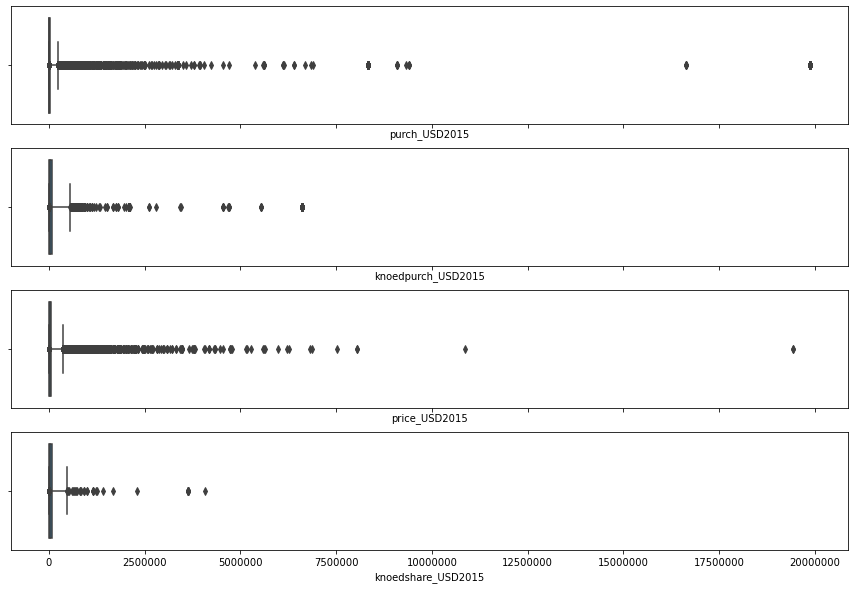

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(15,10), sharex=True)

for i, col in enumerate(cols):
    sns.boxplot(x=knoedler[col], ax=axs[i], whis=[5,95])

plt.ticklabel_format(style='plain', axis='x')

These boxplots confirm my suspicion: There are so many outliers at the high end (all the dots to the right of the whiskers indicate datapoints that lie above the 95th percentile) that the boxplot itself, the entire interquartile range, is squashed into a vertical line.

This is not necessarily implausible, I think. Just means that over the course of tens of thousands of transactions, there were occasionally quite large transations. However, another thing that I've noticed is that there are large amounts of repeated transaction values. Let's look at the <code>purch_USD2015</code> column, for instance.

In [21]:
# Get frequency counts for 'purch_USD2015' column
freq = knoedler['purch_USD2015'].value_counts()

# Create DataFrame to allow for manipulation
freq = pd.DataFrame({'purch_USD2015':freq.index, 'frequency':freq.values})

# View most frequeny purch_USD2015 transaction values
(
    freq
    .head(10)
    .style
    .format({
        "purch_USD2015": "${:,.2f}"
    })
    .hide(axis='index')
)

purch_USD2015,frequency
"$204,832.32",86
"$4,824.99",85
"$2,612.76",50
"$7,838.28",46
"$3,859.99",45
"$5,225.52",41
"$5,082.46",41
"$10,164.91",40
"$9,649.98",40
"$2,486.40",39


Here we can see that there are significant numbers of repeated transaction values in this one category—86 instances of a transaction value adjusted to $204,832.32, for instance. Not all of these repetitions are large values, but let's re-sort this by the first column:

In [22]:
# Sort above DataFrame by value column
(
    freq
    .sort_values(by='purch_USD2015', ascending=False)
    .head(10)
    .style
    .format({
        "purch_USD2015": "${:,.2f}"
    })
    .hide(axis='index')
)

purch_USD2015,frequency
"$19,859,670.32",34
"$16,623,877.52",4
"$9,412,265.79",3
"$9,335,471.43",1
"$9,088,770.91",4
"$8,329,964.10",33
"$6,905,934.23",1
"$6,850,530.40",1
"$6,699,022.85",1
"$6,391,859.12",2


Aha! Something seems to be going on here. 34 transactions, all sharing this maximum value of $19,859,670.32? Followed by other sizeable transactions, many of which are also repeated?

I went back to the <a href="https://github.com/thegetty/provenance-index-csv/tree/master/knoedler" target="_blank">README</a> accompanying the original dataset, and now I understand what's going on. It seems that Knoedler often bought or sold artworks in lots, and in these cases the stockbooks (and thus the dataset) specifies the price for the <i>entire lot</i> and not the individual artwork (for which, of course, there was no individual price assigned in the first place). When this occurs, there will be an explanatory note in an accompanying column (<code>purch_note</code>, <code>knoedpurch_note</code>, <code>price_note</code>, or <code>knoedshare_note</code>).

This, then, would explain the dramatically skewed distribution we're seeing: We would expect there to be some outliers, but in this case our distribution may be even more skewed due to the presence of these multi-artwork lots—which, in addition to being expensive (they consist of multiple artworks, after all), are also repeated (once for every artwork that was part of that lot). This makes our lives a little harder.

I'll start digging into this in the next notebook, and then perhaps we will be in a position to answer the questions with which we began: How did the dealer's 2015-dollar-adjusted revenues change over time? How about its profits change over time? Any observable patterns with purchases and/or sales made in particular currencies? What about solo transactions versus shared transactions?